In [1]:
import GEMVAE

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
dir = r'data\Mouse_Thymus(StereoSec)\adata_RNA.h5ad'
gdata = sc.read_h5ad(dir)
gdata.var_names_make_unique()
gdata

AnnData object with n_obs × n_vars = 4697 × 23622
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [4]:
dir = r'data\Mouse_Thymus(StereoSec)\adata_ADT.h5ad'
pdata = sc.read_h5ad(dir)
pdata.var_names_make_unique()
pdata

AnnData object with n_obs × n_vars = 4697 × 51
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [5]:
# gdata.obsm=adata.obsm
# gdata.uns = adata.uns
# pdata.obsm=adata.obsm
# pdata.uns = adata.uns

In [6]:
#Normalization Gene
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=2200)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

#Normalization Protein 
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

------Calculating spatial graph...
The graph contains 18316 edges, 4697 cells.
3.8995 neighbors per cell on average.


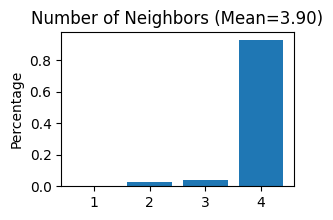

In [7]:
GEMVAE.Cal_Spatial_Net(gdata, rad_cutoff=120)
GEMVAE.Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 18316 edges, 4697 cells.
3.8995 neighbors per cell on average.


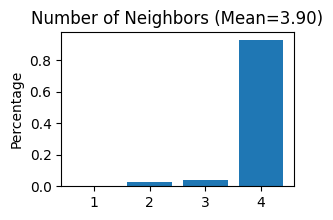

In [8]:
GEMVAE.Cal_Spatial_Net(pdata, rad_cutoff=120)
GEMVAE.Stats_Spatial_Net(pdata)

In [9]:
#parameters 
epochs = 250
hidden_dims_gene = [512,30]
hidden_dims_pro = [128, 30]
alpha = 0.40
pre_resolution_gene = 0.35
pre_resolution_pro = 0.15
save_loss = True

# Loss weights
kl_loss = 0
contrastive_loss = 10
weight_decay_loss = 1.0     #Loss for Ateentions Layers
recon_loss_type = 'ZINB'    # ZINB or MSE
recon_loss = 1

Size of Input for gene data :  (4697, 2200)
Size of Input for protein data :  (4697, 51)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loss weights are =  10 1 1.0 0
START TRAIN
------Pre-clustering Genes using louvain with resolution=0.35
------Pre-clustering Protein using louvain with resolution=0.15
------Pruning the graph...
18316 edges before pruning.
15710 edges after pruning.
------Pruning the graph...
18316 edges before pruning.
17138 edges after pruning.


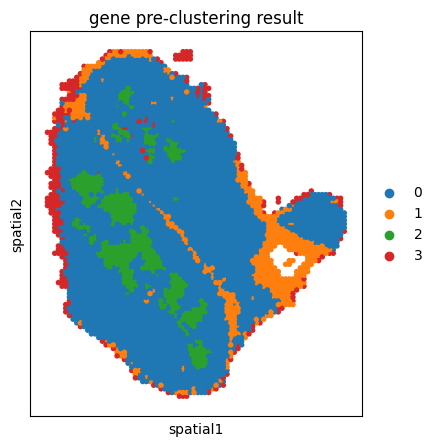

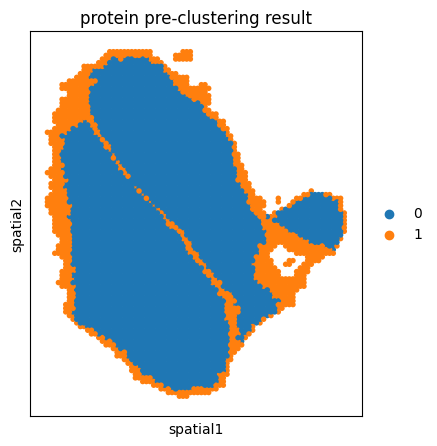

Epoch: 0, Contrastive Loss: 10.3496, Loss: 1842.3446
Epoch: 1, Contrastive Loss: 10.1457, Loss: 1844.0436
Epoch: 2, Contrastive Loss: 10.0049, Loss: 1834.5585
Epoch: 3, Contrastive Loss: 9.8631, Loss: 1833.0543
Epoch: 4, Contrastive Loss: 9.7369, Loss: 1833.4180
Epoch: 5, Contrastive Loss: 9.6316, Loss: 1830.9143
Epoch: 6, Contrastive Loss: 9.5476, Loss: 1830.2686
Epoch: 7, Contrastive Loss: 9.4827, Loss: 1824.8450
Epoch: 8, Contrastive Loss: 9.4336, Loss: 1819.4564
Epoch: 9, Contrastive Loss: 9.3968, Loss: 1823.4987
Epoch: 10, Contrastive Loss: 9.3692, Loss: 1822.9095
Epoch: 11, Contrastive Loss: 9.3485, Loss: 1819.9485
Epoch: 12, Contrastive Loss: 9.3328, Loss: 1816.9446
Epoch: 13, Contrastive Loss: 9.3208, Loss: 1815.2017
Epoch: 14, Contrastive Loss: 9.3116, Loss: 1813.4045
Epoch: 15, Contrastive Loss: 9.3044, Loss: 1815.9283
Epoch: 16, Contrastive Loss: 9.2988, Loss: 1806.6731
Epoch: 17, Contrastive Loss: 9.2944, Loss: 1807.3053
Epoch: 18, Contrastive Loss: 9.2910, Loss: 1803.4269


In [10]:
trained_gdata = GEMVAE.train_GEMVAE(gdata,pdata,n_epochs=epochs,hidden_dims1=hidden_dims_gene,hidden_dims2=hidden_dims_pro,
                                    alpha=alpha,pre_resolution1=pre_resolution_gene,pre_resolution2=pre_resolution_pro, save_loss=save_loss,
                                    kl_loss = kl_loss,
                                    contrastive_loss = contrastive_loss,
                                    weight_decay_loss = weight_decay_loss,       
                                    recon_loss_type = recon_loss_type,   
                                    recon_loss = recon_loss,
                                    task='SSC')

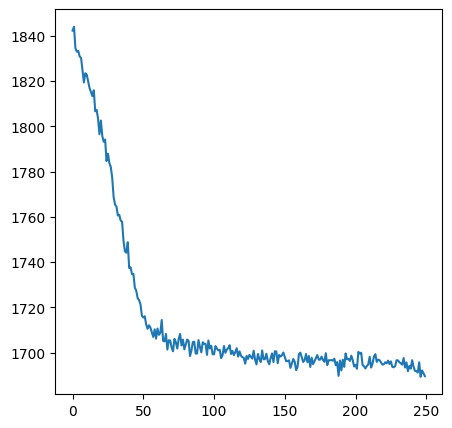

In [11]:
plt.plot(trained_gdata.uns['arch_loss'])
plt.show()

In [12]:
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]

In [13]:
#DEFINE THE NUMBER OF CLUSTERS HERE
n_clusters = 6

In [14]:
for tool in ['mclust','leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print("Using tool : ",tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'])

   # clustering
   if tool == 'mclust':
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=n_clusters, method=tool)
   elif tool in ['leiden']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.05)
   elif tool in ['louvain']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.05)

Using tool :  mclust


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Using tool :  leiden
Searching resolution...
resolution=1.26, cluster number=11
resolution=1.2100000000000002, cluster number=10
resolution=1.1600000000000001, cluster number=10
resolution=1.11, cluster number=10
resolution=1.06, cluster number=8
resolution=1.01, cluster number=8
resolution=0.9600000000000001, cluster number=8
resolution=0.91, cluster number=8
resolution=0.8600000000000001, cluster number=8
resolution=0.81, cluster number=7
resolution=0.76, cluster number=7
resolution=0.7100000000000001, cluster number=6
Using tool :  louvain
Searching resolution...
resolution=1.26, cluster number=9
resolution=1.2100000000000002, cluster number=9
resolution=1.1600000000000001, cluster number=9
resolution=1.11, cluster number=9
resolution=1.06, cluster number=9
resolution=1.01, cluster number=8
resolution=0.9600000000000001, cluster number=7
resolution=0.91, cluster number=7
resolution=0.86000000

Visualizing the clusters

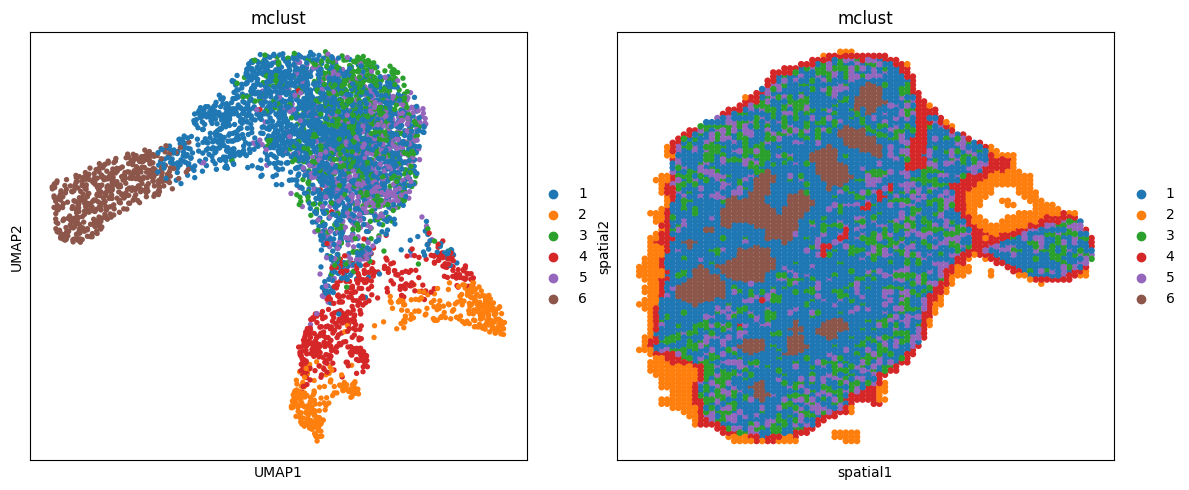

In [15]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

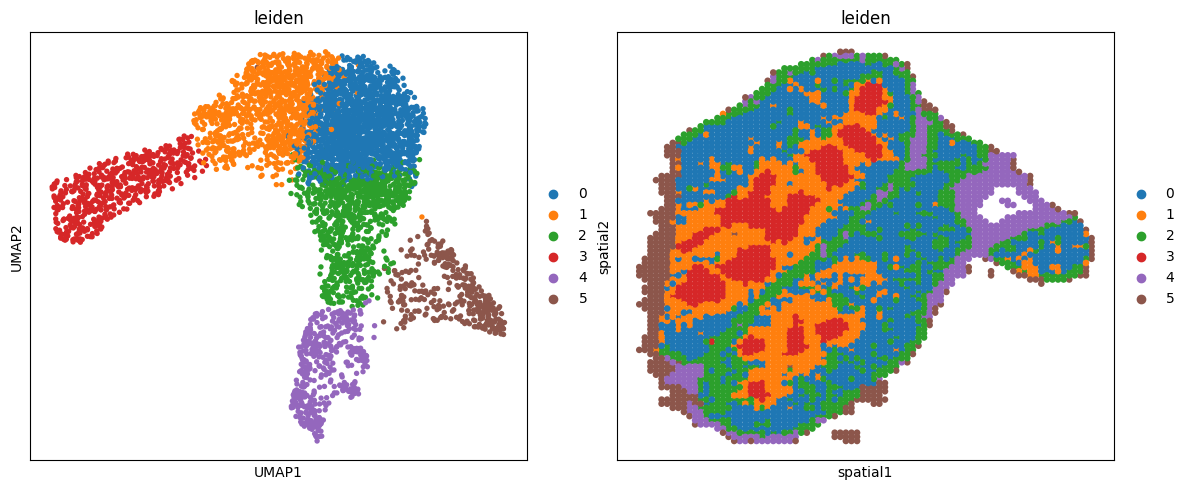

In [16]:
# visualization leiden
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='leiden', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='leiden', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

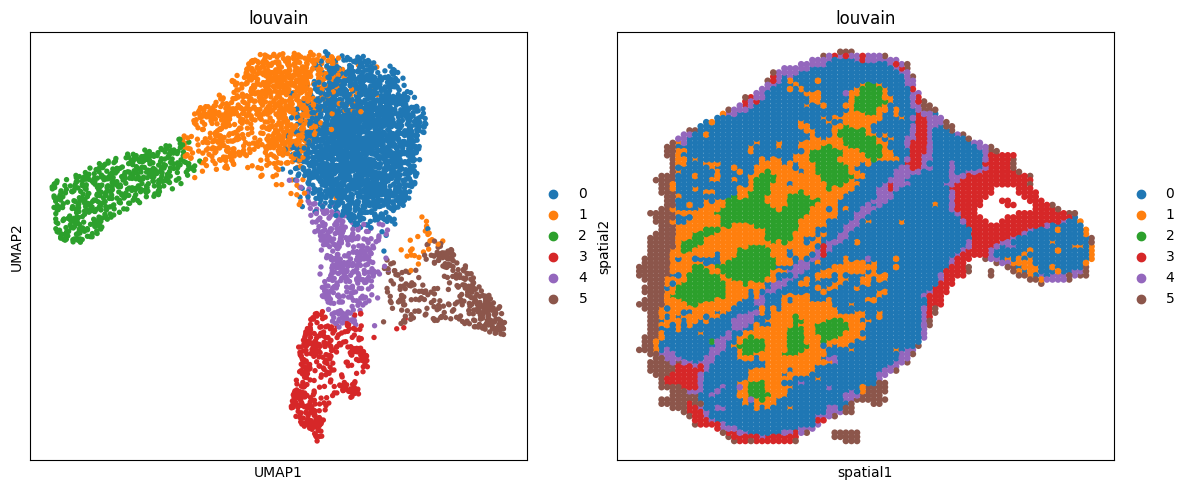

In [17]:
# visualization louven
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='3', ax=ax_list[0], title='louvain', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='3', ax=ax_list[1], title='louvain', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()